# Towards Optimal Synthesis of Reactive Ouput-Feedback Controllers

# Motivation

- Would be excellent if we can automatically synthesize output feedback controllers, which we could guarantee are optimal according to some metric.




____

- Would like to be able to verify these controllers via the safety verification method (or something close to that) described in Barry, Majumdar, Tedrake *(2012)*.
 - (This work provided a great tool to check a given controller.  Left controller synthesis to future work.)

 
____

- For "quads-in-the-real-world" (outside, at respectable speeds, like in FLA), there may be an increasing utility of reactive controllers, or at least ones with planning horizons actually limited by real sensors + occlusions

# Approach so far

- Reason about **dynamics of pixels**
- Parameterize all possible obstacle environments via a set of basis functions
- Use ODE approximation of pixels PDE
- Optimization over possible controllers (starting just  with linear combination)

In [9]:
import IPython.html.widgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from planeVis import plotPlane

%matplotlib inline

Consider a known function $s$ which maps from $[-\frac{\theta_{FOV}}{2},\frac{\theta_{FOV}}{2}]$ to the raycasted distance to an obstacle, where $S_{max}$ is the moving maximum sensing horizon of the sensor.

$$s: [-\frac{\theta_{FOV}}{2},\frac{\theta_{FOV}}{2}] \rightarrow [0,S_{max}] $$

The function $s$ clearly has discontinuities (should be piecewise continuous), but we might be able to approximate $s$ as continuous.  (Would let us treat as not a hybrid system).

### 2D Dubin's Plane

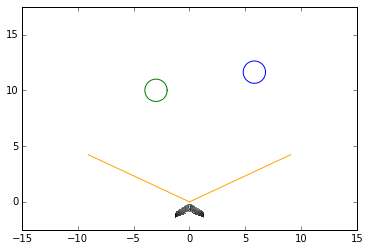

In [10]:
theta_slider = widgets.FloatSlider(min=-90, max=90, step=1, value=0)
w=widgets.interactive(plotPlane,theta_deg=theta_slider)
display(w)


As a special case, we first focus on a sensor that has a 360 degree field of view (FOV), and we can later consider the problem of having obstacles move in and out of sensor FOV:

$$s: [-\pi,\pi] \rightarrow [0,S_{max}] $$

### RotatingBot

In [11]:
import os
import io
import base64
from IPython.display import HTML

video = io.open('/Users/pflomacpro/GeometricPDEs/_RotatingBot/bot_h264.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

The distance $s$ may also be thought of as the Euclidean distance from the $0$-level-set of the signed distance function (SDF) for the set of obstacles.  A side-effect benefit of this approach is that we can naturally use implicit surface representations produced by fusion algorithms of depth sensor information (i.e. Kinect Fusion, etc.)

What we need to find is a geometric PDE that looks something like:

$$ \frac{\partial}{\partial t}  s(\theta)  = f(s,\psi, \dot{\psi})$$

And in our Dubin's car model (assume constant linear velocity too) we can directly control $\dot{\psi} = u$ and would like to do so as a function of $s$ only.  ($u=u(s)$):

$$ \frac{\partial}{\partial t}  s(\theta)  = f(s,\psi, u(s))$$

Where $\psi$ is the yaw of the UAV and $u$ is some control input. 

The control input $u$ may be calculated via a reactive controller, for example of the form:

$$ u = k_1\int w_1(\theta)s(\theta)d\theta + k_2\int w_s(\theta)s(\theta)d\theta$$

Barry, Majumdar, Tedrake 2012 can then tell us where the controller is safe, and where it's not.

# Getting to an ODE for pixel dynamics

What we would really like to do is, given a finite dimensional approximation of all possible obstacle environments, be able to search for the optimal output feedback controller that applies to all possible environments.

Hence we need to use a finite dimensional space to approximate the function $s$.

Given some vector of basis functions $\mathbf{w}$ and vector of weights $\mathbf{c}$ we can approximate $s$ as:

$$ s(\theta) \approx c_1w_1(\theta) + c_2w_2(\theta) + ... + c_Nw_n(\theta) $$

Which then gives us a PDE that approximates $f$:

$$ \frac{\partial}{\partial t} s(\theta) \approx \dot{c}_1w_1(\theta) + \dot{c}_2w_2(\theta) + ... + \dot{c}_Nw_N(\theta) $$

$$ \approx f(s,\psi, \dot{\psi})$$

Let us define that:

$$ s_{approx}(\theta) = c_1w_1(\theta) + c_2w_2(\theta) + ... + c_Nw_n(\theta) $$

$$ \frac{\partial}{\partial t} s_{approx}(\theta) = \dot{c}_1w_1(\theta) + \dot{c}_2w_2(\theta) + ... + \dot{c}_Nw_N(\theta) $$

We can now instead think of $f$ as a vector $\mathbf{f}$ which is a function $\mathbf{f}(c_0,c_1,...,c_N,\theta,\dot{\psi)}$, and whose elements are $f_1, f_2, ..., f_N$.  Also write $\mathbf{c}$ as the vector $\mathbf{c} = (c_1,c_2,...,c_N)$.  

We now have an ODE for the weights:

$$ \frac{d}{d t} \mathbf{c} = \begin{pmatrix}
        f_1(\mathbf{c}, \dot{\psi}) \\
        f_2(\mathbf{c}, \dot{\psi}) \\
        \vdots \\
        f_N(\mathbf{c}, \dot{\psi}) \\
        \end{pmatrix} $$



## PDE for RotatingBot

Believe that our PDE is:

$$ \frac{\partial s}{\partial t} = \frac{\partial s}{\partial \theta} \dot{\psi} $$

Where $s(\theta,t)$ is the distance to an obstacle at time $t$ and angle $\theta$, and $\dot{\psi}$ is the rate of rotation of the vehicle.  If we assume that we can directly control the rate of change, then $u = \dot{\psi}$ and we have:

$$ \frac{\partial s}{\partial t} = \frac{\partial s}{\partial \theta} u $$

# Controller synthesis

Want to maximize some property of $\mathbf{c} \in \mathbb{R}^n$ (where $n = $ # of basis functions) that corresponds to the size of the safety-verified set of conditions $\mathbf{c}_{t=0}$.

The easiest is to imagine a linear combination:

$$u=\mathbf{K} \cdot \mathbf{c} $$.  

Where $\mathbf{K}^{1 \times n}, \mathbf{c}^{n \times 1}$. We can either hand-design $K$ or we can search for a $K$ that maximizes the safety-verified set over $\mathbf{c}$.

There are a few different ideas of what property to maximize.

1. Maximize volume.  For this, we may need to bound $\mathbf{c}_{t=0}$ as $\{\mathbf{c}_{t=0} \in [0, S_{max}] \subset \mathbb{R}^n\}$ (Ani says not known how to do with SOS).
2. Maximize the minimum $c_{min}$.  For this, we may want to choose only a subset $c_{i:j}$ where $i,...,j$ represent the coefficients of the basis functions in the middle in front of us, only the ones that we care about not hitting. (Ani says may be possible with SOS).
3. Maximize some sphere around a point in $R^n$. May again only want to think about $R^k$ where $k = j - i$. (Ani says can do with SOS).

Each element of $\mathbf{K}$ would be a decision variable our optimization. 

### Choice of basis functions

A polynomial basis would naturally lead to SOS verification.  It might not be easy, however, to know how to "stay away" from the weights $\textbf{c}$ of polynomial bases.  (It is not clear how each $c_i$ should indicate where obstacles are).

Some options to consider:

- polynomials
- trig polynomials
- linear combinations of Gaussians
- inverse quadratic $\phi(r) = \frac{1}{1 + (\epsilon r)^2} $

Set of basis functions needs to be:

- closed under addition
- closed under scaling
- closed under multiplication

### Periodic over 2$\pi$

Maybe not necessary, but probably ideal

Currently trying Fourier series approximations to a linear combination of three Gaussians:

- A trick is that it is better to use a linear combination of three Gaussians separated by $2\pi$, so then the periodicity is naturally imposed.  

- Need to pick the degree of the Fourier series approximation, and this fit is dependent on the sharpness (variance) of the chosen Gaussians.  

- Note that in this Fourier formulation, there are two "layers" of weights.  For each basis function, there are the Fourier weights (numbering $2M$, where $M$ is the degree of the approximation) and this is collectively considered a basis function.... are two eighting of the entire basis function becomes an element in $\mathbf{c}$

#### Creating basis functions

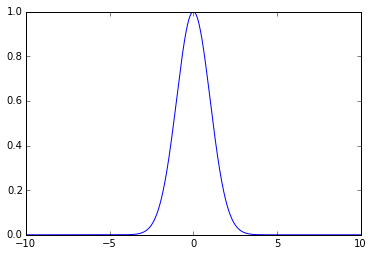

--------
m = 1
[0.39887, 0.485214]
[0.0, 0.0]


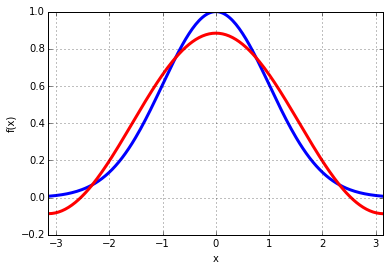

--------
m = 2
[0.39887, 0.485214, 0.106435]
[0.0, 0.0, 0.0]


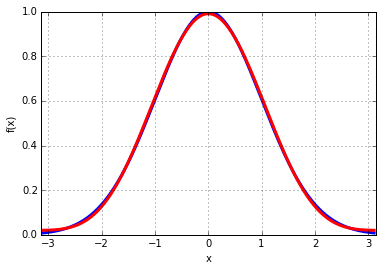

--------
m = 3
[0.39887, 0.485214, 0.106435, 0.00955956]
[0.0, 0.0, 0.0, 0.0]


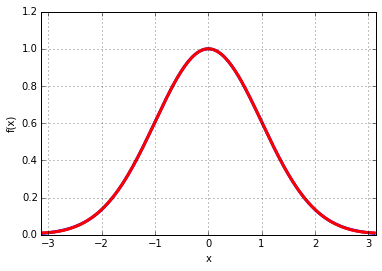

--------
m = 4
[0.39887, 0.485214, 0.106435, 0.00955956, -0.000333174]
[0.0, 0.0, 0.0, 0.0, 0.0]


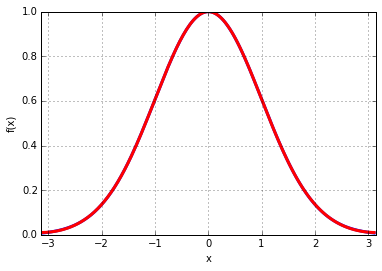

--------
m = 5
[0.39887, 0.485214, 0.106435, 0.00955956, -0.000333174, 0.00044391]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


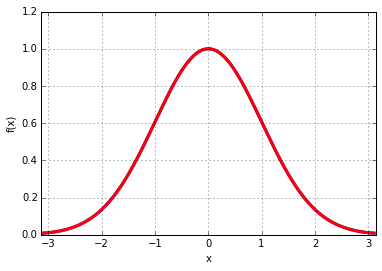

--------
m = 6
[0.39887, 0.485214, 0.106435, 0.00955956, -0.000333174, 0.00044391, -0.000333209]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


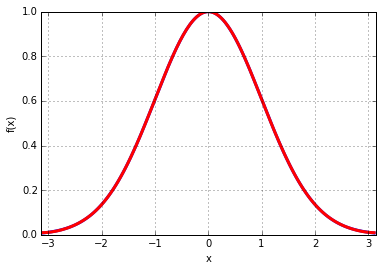

In [12]:
import math
from sympy.mpmath import *
I = [-math.pi, math.pi]
f = lambda x: 2.71 ** (-(x-0)**2 / (2 * 1**2))

x = np.linspace(-10,10,1000)
y = f(x) 

plt.plot(x,y)
plt.show()

M = 6
for i in range(1,M+1): 
    print "--------"
    print "m = " + str(i)
    cs = fourier(f, I, i)
    nprint(cs[0])
    nprint(cs[1])
    plot([f, lambda x: fourierval(cs, I, x)], I)
    plt.show()

-3.14


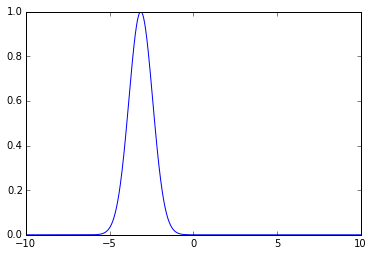

[0.141517, -0.220154, 0.103578, -0.029429]
[0.0, -0.135799, 0.17183, -0.136457]


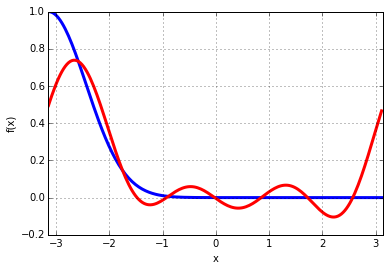

-2.44222222222


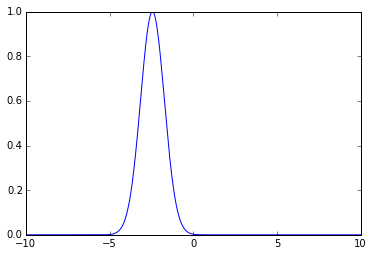

[0.236845, -0.255329, -0.0227202, 0.0657521]
[0.0, -0.314248, 0.252595, -0.101623]


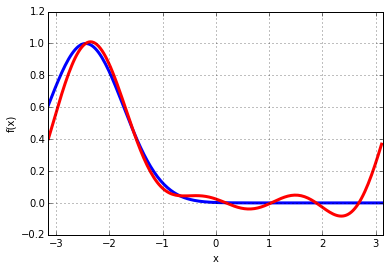

-1.74444444444


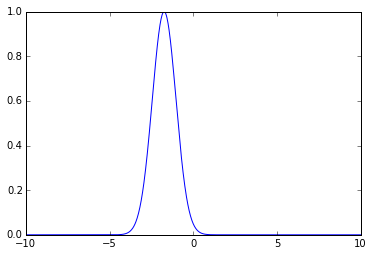

[0.275673, -0.0631134, -0.205607, 0.0376717]
[0.0, -0.436576, 0.0764846, 0.0441777]


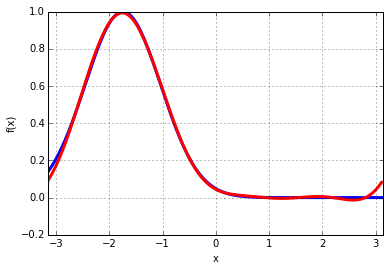

-1.04666666667


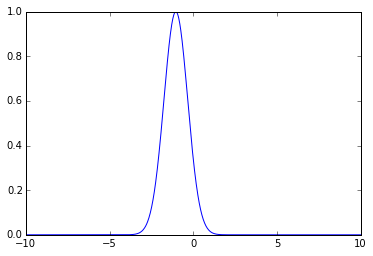

[0.282089, 0.220907, -0.104182, -0.0585081]
[0.0, -0.380869, -0.179271, -0.000495757]


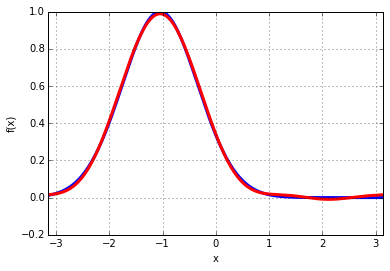

-0.348888888889


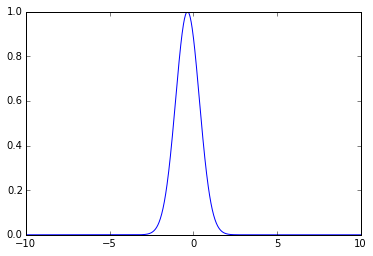

[0.282515, 0.413257, 0.158778, 0.0296195]
[0.0, -0.150326, -0.133146, -0.0512164]


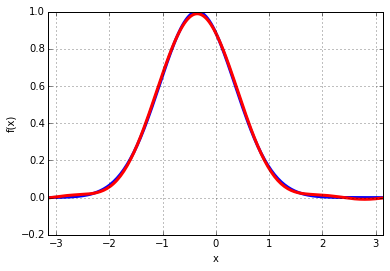

0.348888888889


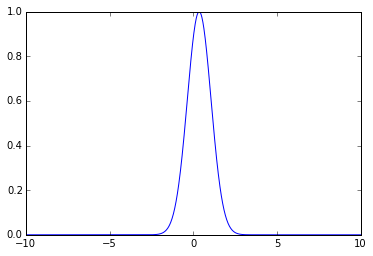

[0.282515, 0.413257, 0.158778, 0.0296195]
[0.0, 0.150326, 0.133146, 0.0512164]


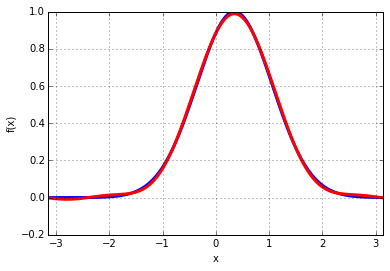

1.04666666667


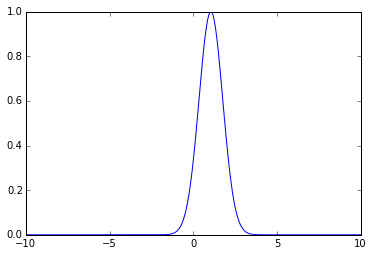

[0.282089, 0.220907, -0.104182, -0.0585081]
[0.0, 0.380869, 0.179271, 0.000495757]


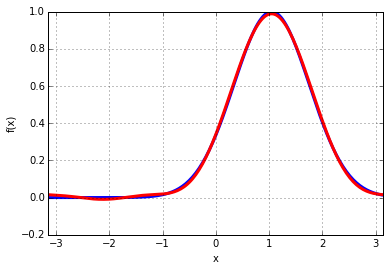

1.74444444444


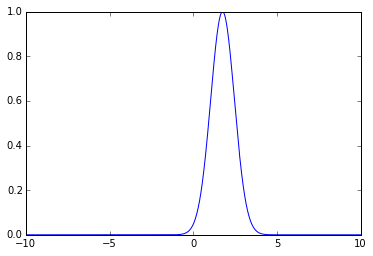

[0.275673, -0.0631134, -0.205607, 0.0376717]
[0.0, 0.436576, -0.0764846, -0.0441777]


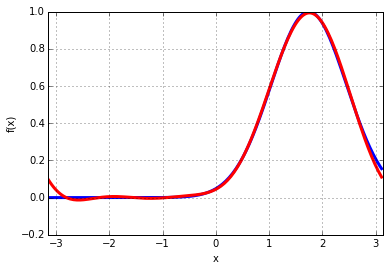

2.44222222222


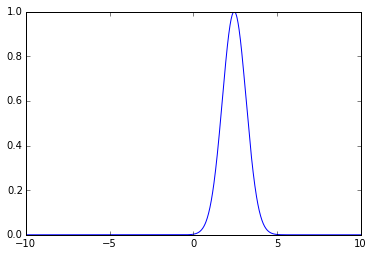

[0.236845, -0.255329, -0.0227202, 0.0657521]
[0.0, 0.314248, -0.252595, 0.101623]


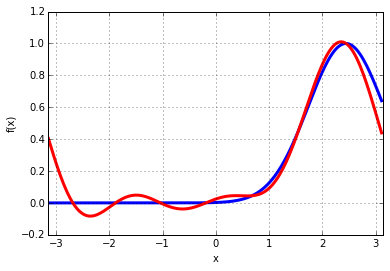

3.14


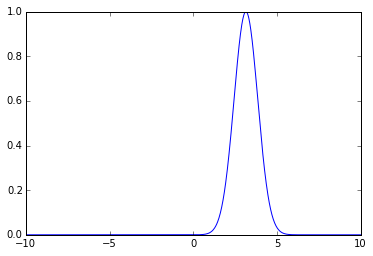

[0.141517, -0.220154, 0.103578, -0.029429]
[0.0, 0.135799, -0.17183, 0.136457]


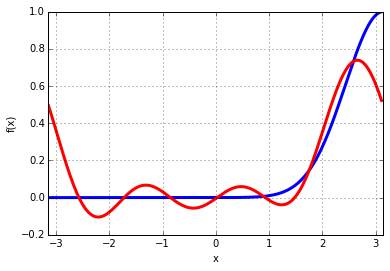

In [13]:
# Approximation of just one Gaussian over the range [-pi,pi]

from sympy.mpmath import *
I = [-math.pi, math.pi]
N = 10
M=3
for i in np.linspace(-3.14,3.14,10):
    print i

    f = lambda x: 2.71 ** (-(x-i)**2)

    x = np.linspace(-10,10,1000)
    y = f(x) 
    plt.plot(x,y)
    plt.show()
 
    cs = fourier(f, I, M)
    nprint(cs[0])
    nprint(cs[1])
    plot([f, lambda x: fourierval(cs, I, x)], I)
    plt.show()

-3.14


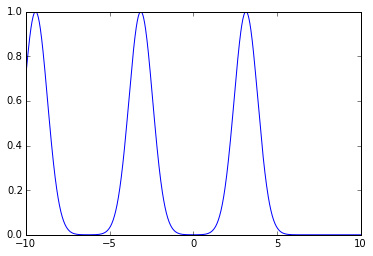

[0.282526, -0.439726, 0.207235, -0.0591467]
[0.0, -0.000700332, 0.000660109, -0.000282603]


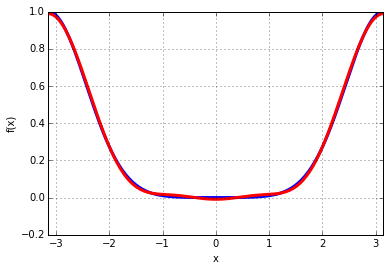

-2.59504132231


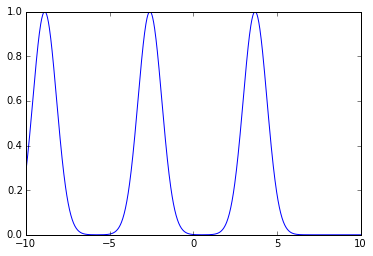

[0.282526, -0.375668, 0.095273, 0.00406953]
[0.0, -0.228545, 0.184037, -0.0590072]


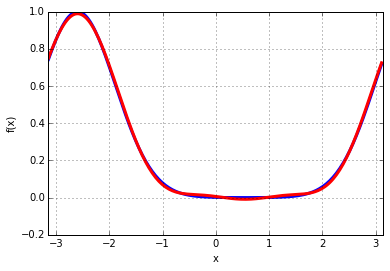

-2.05008264463


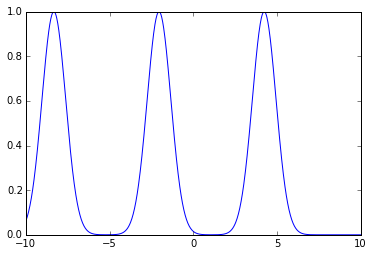

[0.282526, -0.202778, -0.119096, 0.0586255]
[0.0, -0.39018, 0.169596, 0.00783975]


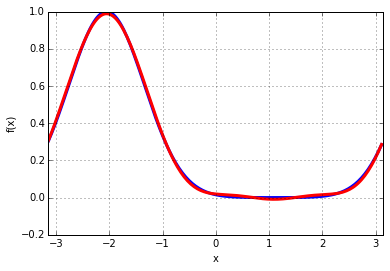

-1.50512396694


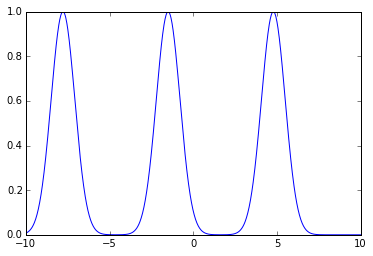

[0.282526, 0.0288571, -0.205451, -0.0115778]
[0.0, -0.438779, -0.0271411, 0.0580031]


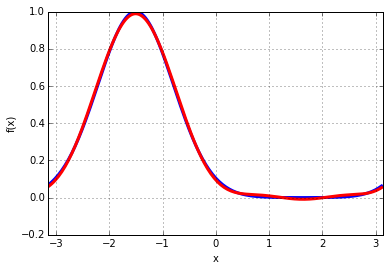

-0.960165289256


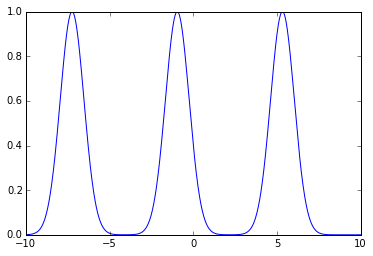

[0.282526, 0.252132, -0.0709701, -0.0571427]
[0.0, -0.360262, -0.194705, -0.0152683]


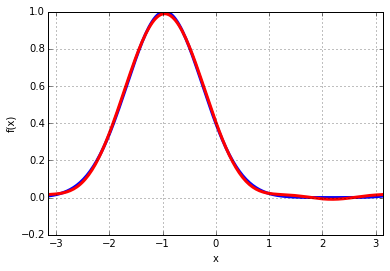

-0.41520661157


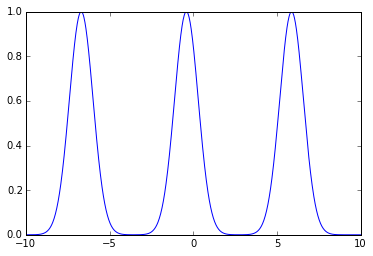

[0.282526, 0.402364, 0.139795, 0.0188962]
[0.0, -0.177376, -0.152984, -0.0560477]


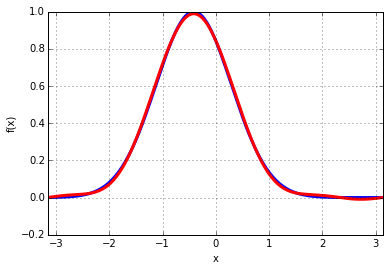

0.129752066116


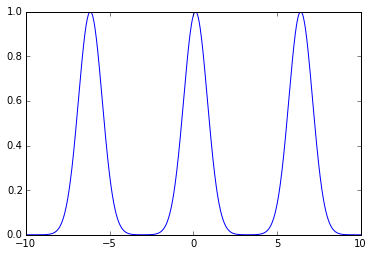

[0.282526, 0.43603, 0.200297, 0.0547226]
[0.0, 0.0568955, 0.053177, 0.0224464]


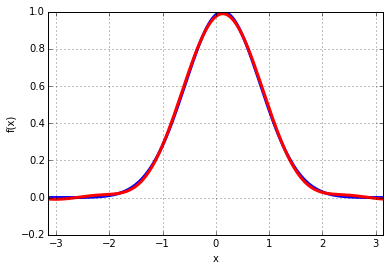

0.674710743802


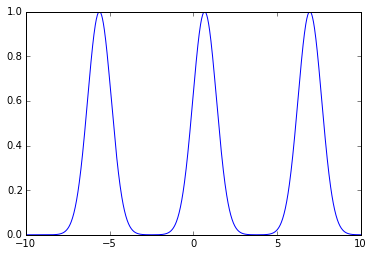

[0.282526, 0.343377, 0.045503, -0.0259046]
[0.0, 0.274685, 0.202179, 0.0531729]


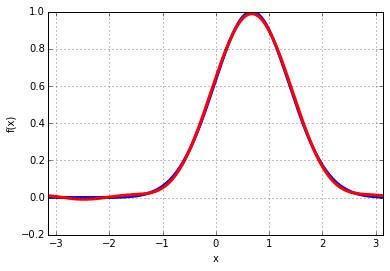

1.21966942149


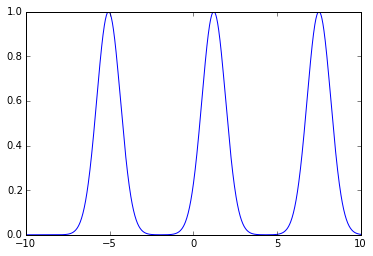

[0.282526, 0.151247, -0.158201, -0.051405]
[0.0, 0.412897, 0.133862, -0.0292564]


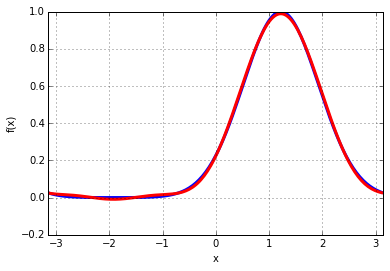

1.76462809917


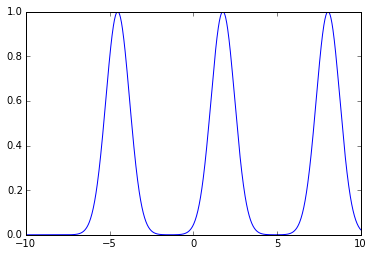

[0.282526, -0.0847003, -0.191858, 0.0324881]
[0.0, 0.431492, -0.0783406, -0.049426]


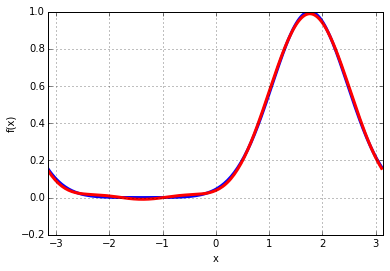

2.30958677686


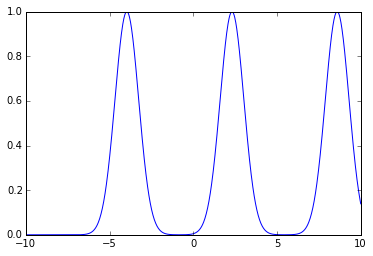

[0.282526, -0.296109, -0.0192896, 0.0472442]
[0.0, 0.325083, -0.206336, 0.0355865]


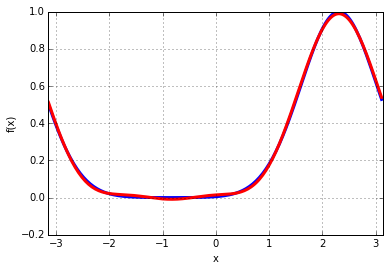

2.85454545455


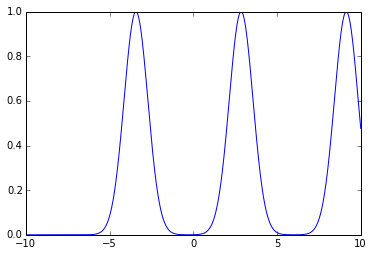

[0.282526, -0.421735, 0.174013, -0.0385387]
[0.0, 0.124496, -0.112545, 0.0448684]


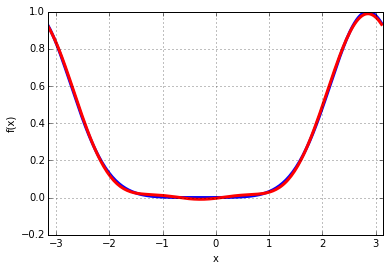

In [14]:
# Approximation of linear combination of three Gaussians (separated by 2pi) over the range [-pi,pi]

from sympy.mpmath import *
I = [-math.pi, math.pi]
N = 12   # number of Fourier-approximation-of-3-Gaussian basis functions
M = 3    # order of Fourier series
for i in np.linspace(-3.14,3.14-3.14/11,N):
    print i

    f = lambda x: 2.71 ** (-(x-i)**2) + 2.71 ** (-(x-i-2*math.pi)**2) + 2.71 ** (-(x-i+2*math.pi)**2)

    x = np.linspace(-10,10,1000)
    y = f(x) 
    plt.plot(x,y)
    plt.show()
 
    cs = fourier(f, I, M)
    nprint(cs[0])
    nprint(cs[1])
    plot([f, lambda x: fourierval(cs, I, x)], I)
    plt.show()

-3.14


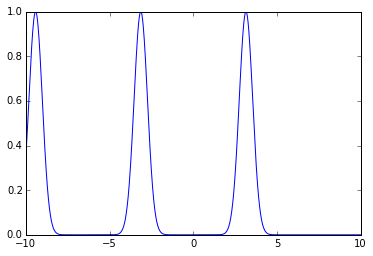

[0.159821, -0.294994, 0.231879, -0.155242, 0.0885231, -0.0429935, 0.0177847]
[0.0, -0.000469824, 0.000738609, -0.000741746, 0.000563954, -0.000342376, 0.000169955]


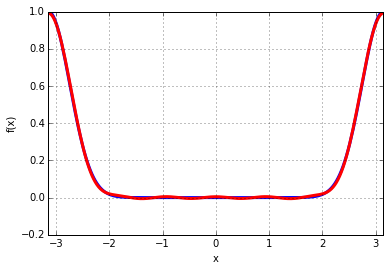

-2.59504132231


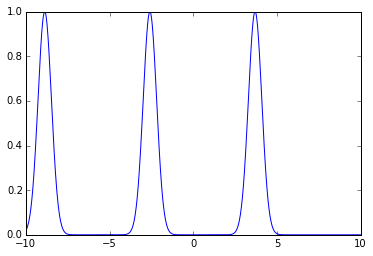

[0.159821, -0.25202, 0.106603, 0.0106813, -0.0511047, 0.0394514, -0.0176172]
[0.0, -0.153322, 0.205923, -0.154876, 0.0722839, -0.0170922, -0.00244161]


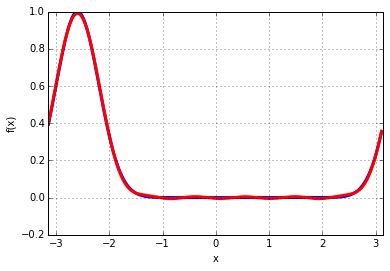

-2.05008264463


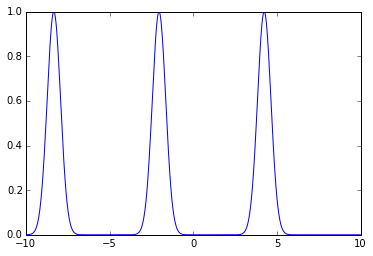

[0.159821, -0.136035, -0.133259, 0.153874, -0.0300512, -0.0291544, 0.0171606]
[0.0, -0.261756, 0.189764, 0.020577, -0.0832681, 0.0316003, 0.00467321]


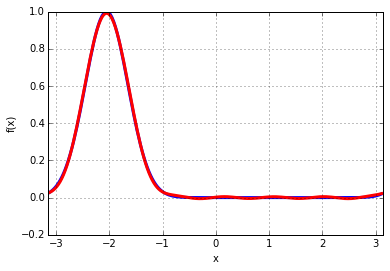

-1.50512396694


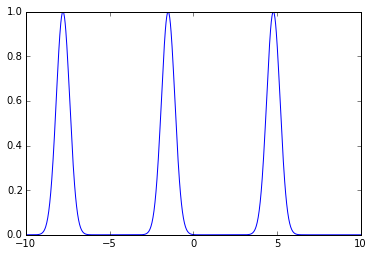

[0.159821, 0.0193591, -0.229883, -0.0303882, 0.085488, 0.0138655, -0.0164226]
[0.0, -0.294358, -0.0303688, 0.152241, 0.022988, -0.0406977, -0.00682817]


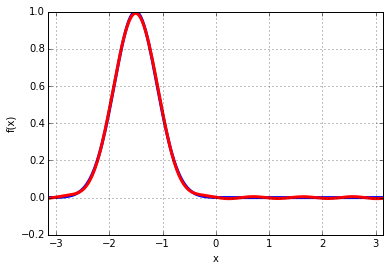

-0.960165289256


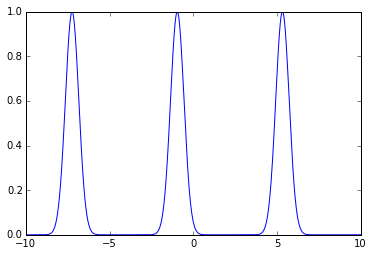

[0.159821, 0.169145, -0.0794098, -0.149982, -0.0677606, 0.0037974, 0.0154152]
[0.0, -0.241685, -0.217859, -0.0400747, 0.0569662, 0.0428268, 0.00887112]


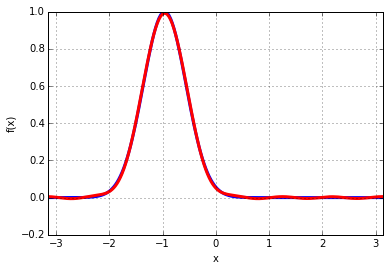

-0.41520661157


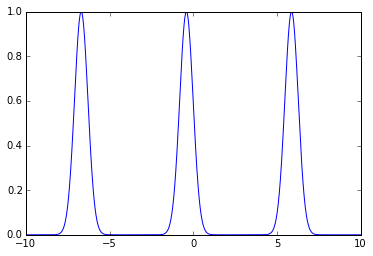

[0.159821, 0.26993, 0.15642, 0.0495967, -0.00795914, -0.0208101, -0.014155]
[0.0, -0.118995, -0.171176, -0.147108, -0.0881663, -0.037623, -0.0107686]


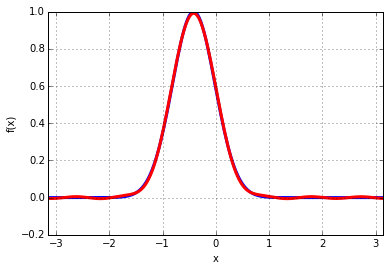

0.129752066116


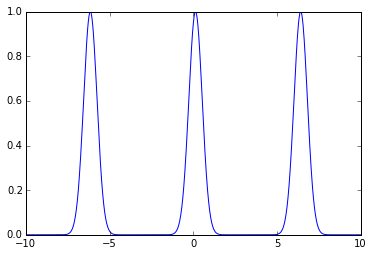

[0.159821, 0.292515, 0.224116, 0.14363, 0.0768672, 0.0342597, 0.0126626]
[0.0, 0.0381688, 0.0595008, 0.0589151, 0.04391, 0.0259774, 0.0124894]


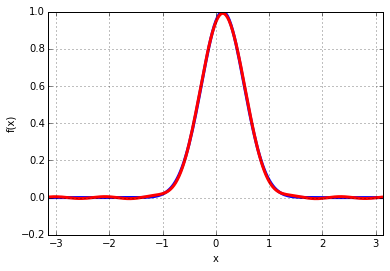

0.674710743802


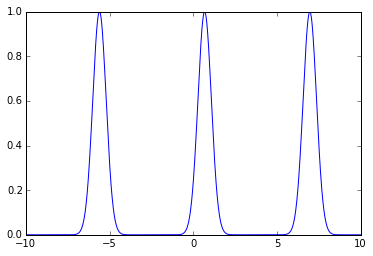

[0.159821, 0.230357, 0.0509142, -0.0679917, -0.079989, -0.0418433, -0.0109625]
[0.0, 0.184275, 0.226222, 0.139563, 0.0379263, -0.00988393, -0.0140054]


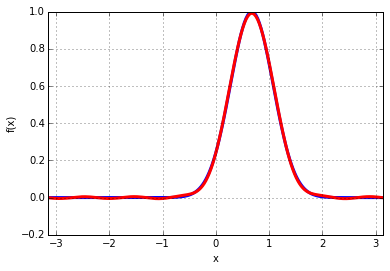

1.21966942149


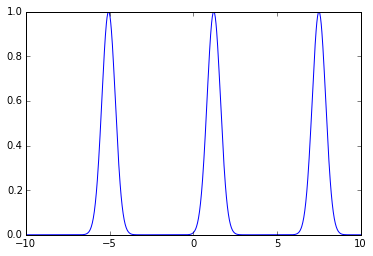

[0.159821, 0.101465, -0.177015, -0.134923, 0.0146529, 0.0422625, 0.00908257]
[0.0, 0.276996, 0.149781, -0.0767892, -0.0873037, -0.00790191, 0.0152916]


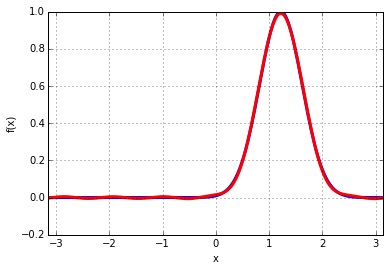

1.76462809917


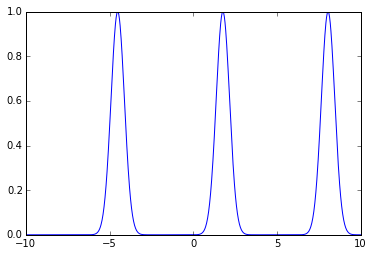

[0.159821, -0.0568219, -0.214674, 0.0852715, 0.0632238, -0.0354454, -0.00705368]
[0.0, 0.28947, -0.0876569, -0.129728, 0.061963, 0.0243348, -0.016327]


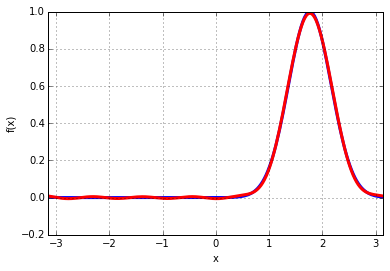

2.30958677686


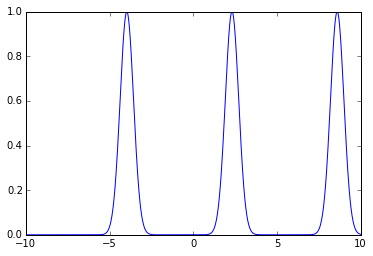

[0.159821, -0.198648, -0.0215835, 0.124002, -0.0869909, 0.0225593, 0.00490909]
[0.0, 0.218085, -0.230874, 0.0934037, 0.0164083, -0.036601, 0.0170946]


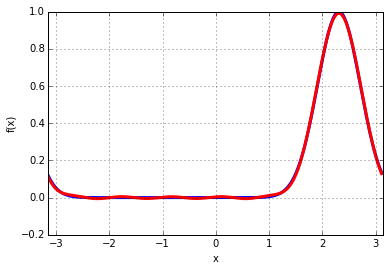

2.85454545455


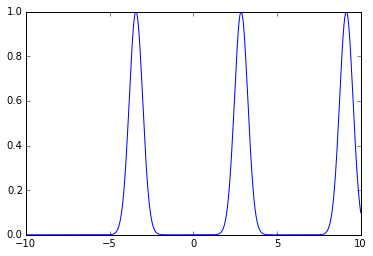

[0.159821, -0.282924, 0.194706, -0.101153, 0.0363076, -0.00581056, -0.00268398]
[0.0, 0.0835192, -0.125928, 0.117766, -0.0807367, 0.0426004, -0.0175819]


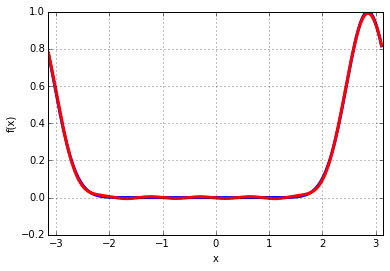

-3.14
-2.59504132231
-2.05008264463
-1.50512396694
-0.960165289256
-0.41520661157
0.129752066116
0.674710743802
1.21966942149
1.76462809917
2.30958677686
2.85454545455


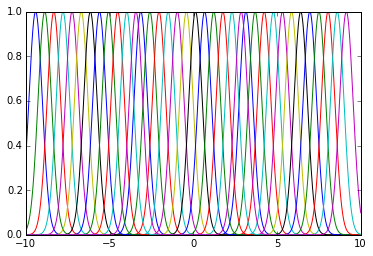

In [15]:
# Approximation of linear combination of three Gaussians (separated by 2pi) over the range [-pi,pi]
# Decreasing variance


from sympy.mpmath import *
I = [-math.pi, math.pi]
N = 12   # number of Fourier-approximation-of-3-Gaussian basis functions
M = 6    # order of Fourier series
sig = 0.4

n = 0

for i in np.linspace(-3.14,3.14-3.14/11,N):
    n = n + 1
    print i

    f = lambda x: 2.71 ** (-(x-i)**2 / (2*sig**2)) + 2.71 ** (-(x-i-2*math.pi)**2 / (2*sig**2)) + 2.71 ** (-(x-i+2*math.pi)**2 / (2*sig**2))

    x = np.linspace(-10,10,1000)
    y = f(x) 
    plt.plot(x,y)
    plt.show()
 
    cs = fourier(f, I, M)
    nprint(cs[0])
    nprint(cs[1])
    plot([f, lambda x: fourierval(cs, I, x)], I)
    plt.show()
    
    
for i in np.linspace(-3.14,3.14-3.14/11,N):
    print i

    f = lambda x: 2.71 ** (-(x-i)**2 / (2*sig**2)) + 2.71 ** (-(x-i-2*math.pi)**2 / (2*sig**2)) + 2.71 ** (-(x-i+2*math.pi)**2 / (2*sig**2))

    x = np.linspace(-10,10,1000)
    y = f(x) 
    plt.plot(x,y)

plt.show()
    

-3.14
-2.59504132231
-2.05008264463
-1.50512396694
-0.960165289256
-0.41520661157
0.129752066116
0.674710743802
1.21966942149
1.76462809917
2.30958677686
2.85454545455


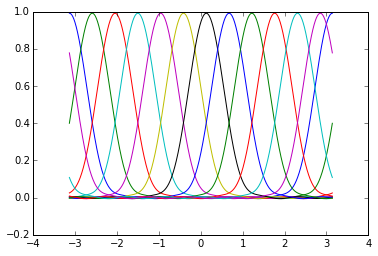

In [17]:
cslist = []

M=6
for i in np.linspace(-3.14,3.14-3.14/11,N):
    print i

    f = lambda x: 2.71 ** (-(x-i)**2 / (2*sig**2)) + 2.71 ** (-(x-i-2*math.pi)**2 / (2*sig**2)) + 2.71 ** (-(x-i+2*math.pi)**2 / (2*sig**2))

    x = np.linspace(-10,10,1000)
    y = f(x) 
    cs = fourier(f, I, M)
    cslist.append(cs)

for i in range(len(cslist)):
    cs = cslist[i]

    def f_basis_practice(x):
        b = math.pi
        a = -math.pi
        m = 2.0*math.pi / (b - a)
        y = 0
        M = 6
        for k in range(M+1):

            y = y + cs[0][k] * math.cos(k * m * x)
            y = y + cs[1][k] * math.sin(k * m * x)
        return y

    x = np.linspace(-math.pi,math.pi,1000)
    y = x * 0.0
    for i in range(len(x)):
        y[i] = f_basis_practice(x[i])

    plt.plot(x,y)
    
plt.show()

How to determine each $f_i$?

Here's what I'm thinking:

- What we want to know is just whether each weight, $c_i$, is increasing or decreasing and at what rate.  $c_i$ is just a scalar weight, all it can do is go up or down

- Clearly the derivative of $c_i$ needs to depend on what all the other weights $c_1,...,c_n$ are, since as we rotate, the regions that used to belong to $c_i$ will move other to the regions of other basis functions


### Assumptions of the environment

Will always assume that there is an obstacle ($s=0$) wherever we cannot see.

Can also assume that there are obstacles immediately beyond our maximum sensor distance ($s=S_{max}$).

### Memory of environment

We would like to be able to deal with the issue of seeing something, then turning away from it, but being able to remember it was there.  

One way to be able to do this is to have our basis functions defined over the entire domain $[0,2\pi]$.  This generalizes easily to when we have sensors that can see a full 360 degrees. For sensors with limited FOVs, we could make our basis functions decay near the edges.  It is possible that we may naturally impose *memory leakage* if our basis functions cause information outside of our FOV to be naturaly drawn down farther.  One option would be to regularize basis functions outside of the FOV.

### Choice of basis functions

A polynomial basis would naturally lead to SOS verification.  It might not be easy, however, to know how to "stay away" from the weights $\textbf{c}$ of polynomial bases.  (It is not clear how each $c_i$ should indicate where obstacles are).

An easy choice of basis functions would be preiodic (over $2\pi$) step functions, but then we would worry about hybrid dynamics.

A similar choice but one the preserves continuity is radial basis functions.  Gaussian radial basis functions seem to be a fine choice.  Ani thinks we can still do SOS with linear combinations of Gaussians.

Options:

- polynomials
- trig polynomials
- linear combinations of Gaussians
- inverse quadratic $\phi(r) = \frac{1}{1 + (\epsilon r)^2} $

Set of basis functions needs to be:

- closed under addition
- closed under scaling
- closed under multiplication

Ani says we can only have up to 12 or 13 basis functions if we're going to use SOS.

To look into later: SOS beyond 12/13


**Periodic over 2$\pi$**

It is possible that we won't need functions that are periodic over the unit circle.  It's possible that although the ODE approximation to the PDE will leak out of the unit circle, it might be slow enough that we don't care.  Could try just regular Gaussian radial basis functions.

But perhaps better to have a function that is indeed periodic over the unit circle, so that if we do a 360 degree turn, we end up with the same parameterization of obstacles in front of us.

What I think we want is to have functions that have a uni-modal, tunably sharp peak over the unit circle.  We basically want Gaussian radial basis functions, but ones that are periodic with period $2\pi$.

How can we get those functions?

Am trying a Fourier series approximation of Gaussian radial basis function over $[0,2\pi]$.  A trick is that it is better to use a linear combination of three Gaussians separated by $2\pi$, so then the periodicity is naturally imposed.  Need to pick the degree of the Fourier series approximation, and this fit is dependent on the sharpness (variance) of the chosen Gaussians.  Note that in this Fourier formulation, there are two "layers" of weights.  For each basis function, there are the Fourier weights (numbering $2M$, where $M$ is the degree of the approximation) and this is collectively considered a basis function.... are two eighting of the entire basis function becomes an element in $\mathbf{c}$


### Fitting of basis functions to obstacle environment data

Started with least squares so far:

$$ \hat{\mathbf{c}} = (\Theta^T\Theta)^{-1}\Theta^T\textbf{s} $$

Where we have $n$ points $(\theta_i, s_i)$, and are fitting with coefficients $c_1, ..., c_N$ for our $N$ basis functions $\phi_1, ..., \phi_N$:

$$\begin{bmatrix}s_1 \\s_2 \\ \vdots \\ s_n\end{bmatrix} 
= \begin{bmatrix}\phi_1(\theta_1) & \phi_2(\theta_1) & \phi_3(\theta_1) & ... & \phi_N(\theta_1) \\ 
\phi_1(\theta_2) & \phi_2(\theta_2) & \phi_3(\theta_2) & ... & \phi_N(\theta_2) \\ 
\vdots & \vdots & \vdots & \ddots & \vdots \\
\phi_1(\theta_n) & \phi_2(\theta_n) & \phi_3(\theta_n) & ... & \phi_N(\theta_n) \\ 
\end{bmatrix} 
\begin{bmatrix}c_1 \\ c_2 \\ \vdots \\ c_N\end{bmatrix}$$

$$\textbf{s} = \Theta \mathbf{c}$$



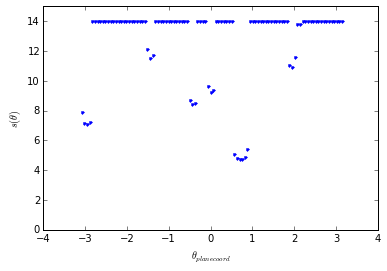

In [25]:
import csv
o = open('laserdata.csv', 'rU')
mydata = csv.reader(o)

laseAngles2 = []
laserDepths = []
for row in mydata:
    laseAngles2.append(float(row[0]))
    laserDepths.append(float(row[1]))
    
#%pylab inline

plt.plot(laseAngles2,laserDepths,'.')
plt.xlabel(r'$\theta_{plane coord}$')
plt.ylabel(r'$s(\theta)$')
plt.axis([-4, 4, 0, 15])
plt.show()

# Approximation of linear combination of three Gaussians (separated by 2pi) over the range [-pi,pi]

from sympy.mpmath import *
I = [-math.pi, math.pi]
N = 12   # number of Fourier-approximation-of-3-Gaussian basis functions
M = 6    # order of Fourier series
sig = 0.4

import os
import io
import base64
from IPython.display import HTML

video = io.open('/Users/pflomacpro/GeometricPDEs/_RotatingBot/bot_h264.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

regression weights for M = 11
[  1.13970930e+01  -4.21410724e+00   9.36249958e-01   4.52966168e+00
   5.88067742e-02  -1.70511269e+00  -6.56744331e-02   2.83536835e-01
   1.01733738e-02  -2.14899960e-02  -5.44870365e-04   6.24294003e-04]


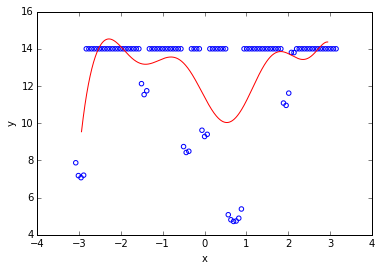

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ -1.24951795e-03   3.52682367e-02   4.96600583e-01 ...,   1.23877309e-03
    1.42468657e-03  -4.24750922e-03]
 [  1.77611472e-03   5.06501668e-02   5.90960762e-01 ...,  -7.82425163e-04
    3.33052919e-03  -5.44798079e-03]
 [  5.01227449e-03   7.36127122e-02   6.84645704e-01 ...,  -2.67807878e-03
    4.67420740e-03  -5.64340475e-03]
 ..., 
 [ -5.69583087e-03   1.56927798e-02   2.47814733e-01 ...,   4.77554444e-03
   -4.12032049e-03   2.23322405e-03]
 [ -5.23447516e-03   1.95202916e-02   3.21970910e-01 ...,   4.28277708e-03
   -2.65887768e-03  -5.23338020e-06]
 [ -3.69178452e-03   2.55126828e-02   4.05768489e-01 ...,   3.03134575e-03
   -6.97070818e-04  -2.30698318e-03]]
regression weights for M = 11
[ -1.52394609   8.44730008   9.45301514   3.79270996  12.37370732
   0.4676806   13.967597

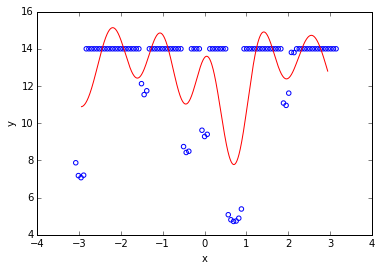

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from linear_regression import LinearRegression
from gradient_descent import GradientDescent, quad, quadGrad
%matplotlib inline

def plot(lr,w):
    # plot sin(2*phi*x) in green
    x = np.linspace(-math.pi+0.2,math.pi-0.2,1000)
    lr_temp = LinearRegression(x,x,lr.numFeatures-1)
    reg_prediction = np.dot(lr_temp.phi,w)
    plt.plot(x, reg_prediction, color='r')
    plt.scatter(lr.x, lr.y, color='b', marker='o',facecolors='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
def plotRBFbases(lr,w):
    # plot sin(2*phi*x) in green
    x = np.linspace(-math.pi+0.2,math.pi-0.2,1000)
    reg_prediction = w[0]*lr.bases[0](x) + w[1]*lr.bases[1](x) + w[2]*lr.bases[2](x) + w[3]*lr.bases[3](x) + \
                     w[4]*lr.bases[4](x) + w[5]*lr.bases[5](x) + w[6]*lr.bases[6](x) + w[7]*lr.bases[7](x) + \
                     w[8]*lr.bases[8](x) + w[9]*lr.bases[9](x) + w[10]*lr.bases[10](x) + w[11]*lr.bases[11](x)
    plt.plot(x, reg_prediction, color='r')
    plt.scatter(lr.x, lr.y, color='b', marker='o',facecolors='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

M = 11
lr = LinearRegression(laseAngles2,laserDepths,M)
w = lr.reg()
w_initial = 0*np.zeros((1,12))
print "regression weights for M = " + str(M)
print w
plot(lr,w)


N = 12
lr = LinearRegression(laseAngles2,laserDepths,11)
lr.setBases(N,cslist)
lr.RBF_Phi(N)
w = lr.reg()
print "regression weights for M = " + str(M)
print w
plotRBFbases(lr,w)




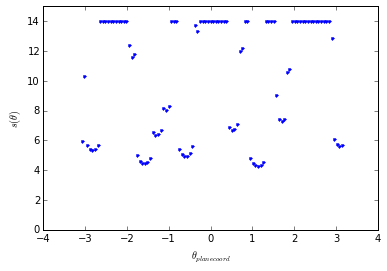

In [22]:
import csv
o = open('laserdata.csv', 'rU')
mydata = csv.reader(o)

laseAngles2 = []
laserDepths = []
for row in mydata:
    laseAngles2.append(float(row[0]))
    laserDepths.append(float(row[1]))
    
#%pylab inline

plt.plot(laseAngles2,laserDepths,'.')
plt.xlabel(r'$\theta_{plane coord}$')
plt.ylabel(r'$s(\theta)$')
plt.axis([-4, 4, 0, 15])
plt.show()

# Approximation of linear combination of three Gaussians (separated by 2pi) over the range [-pi,pi]

from sympy.mpmath import *
I = [-math.pi, math.pi]
N = 12   # number of Fourier-approximation-of-3-Gaussian basis functions
M = 6    # order of Fourier series
sig = 0.4

regression weights for M = 11
[  1.26489316e+01  -5.71527590e-01  -7.58720006e+00   1.89191269e+00
   2.89790554e+00  -6.92728689e-01  -1.77376030e-01   5.42284620e-02
  -3.02236290e-02   5.78196899e-03   2.63180120e-03  -6.32568986e-04]


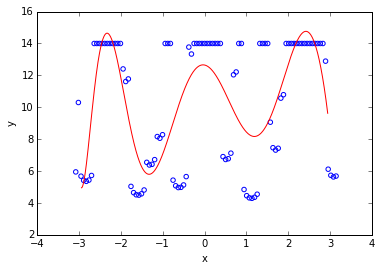

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ -1.24951795e-03   3.52682367e-02   4.96600583e-01 ...,   1.23877309e-03
    1.42468657e-03  -4.24750922e-03]
 [  1.77611472e-03   5.06501668e-02   5.90960762e-01 ...,  -7.82425163e-04
    3.33052919e-03  -5.44798079e-03]
 [  5.01227449e-03   7.36127122e-02   6.84645704e-01 ...,  -2.67807878e-03
    4.67420740e-03  -5.64340475e-03]
 ..., 
 [ -5.69583087e-03   1.56927798e-02   2.47814733e-01 ...,   4.77554444e-03
   -4.12032049e-03   2.23322405e-03]
 [ -5.23447516e-03   1.95202916e-02   3.21970910e-01 ...,   4.28277708e-03
   -2.65887768e-03  -5.23338020e-06]
 [ -3.69178452e-03   2.55126828e-02   4.05768489e-01 ...,   3.03134575e-03
   -6.97070818e-04  -2.30698318e-03]]
regression weights for M = 11
[-10.59268404   9.69921047  10.81829618  -3.71486108  10.64538084
  -1.13435042  15.115853

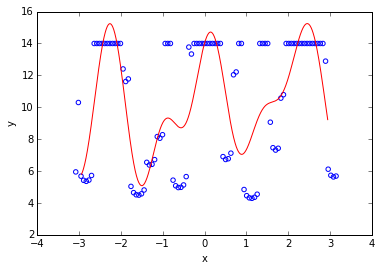

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from linear_regression import LinearRegression
from gradient_descent import GradientDescent, quad, quadGrad
%matplotlib inline

def plot(lr,w):
    # plot sin(2*phi*x) in green
    x = np.linspace(-math.pi+0.2,math.pi-0.2,1000)
    lr_temp = LinearRegression(x,x,lr.numFeatures-1)
    reg_prediction = np.dot(lr_temp.phi,w)
    plt.plot(x, reg_prediction, color='r')
    plt.scatter(lr.x, lr.y, color='b', marker='o',facecolors='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
def plotRBFbases(lr,w):
    # plot sin(2*phi*x) in green
    x = np.linspace(-math.pi+0.2,math.pi-0.2,1000)
    reg_prediction = w[0]*lr.bases[0](x) + w[1]*lr.bases[1](x) + w[2]*lr.bases[2](x) + w[3]*lr.bases[3](x) + \
                     w[4]*lr.bases[4](x) + w[5]*lr.bases[5](x) + w[6]*lr.bases[6](x) + w[7]*lr.bases[7](x) + \
                     w[8]*lr.bases[8](x) + w[9]*lr.bases[9](x) + w[10]*lr.bases[10](x) + w[11]*lr.bases[11](x)
    plt.plot(x, reg_prediction, color='r')
    plt.scatter(lr.x, lr.y, color='b', marker='o',facecolors='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

M = 11
lr = LinearRegression(laseAngles2,laserDepths,M)
w = lr.reg()
w_initial = 0*np.zeros((1,12))
print "regression weights for M = " + str(M)
print w
plot(lr,w)


N = 12
lr = LinearRegression(laseAngles2,laserDepths,11)
lr.setBases(N,cslist)
lr.RBF_Phi(N)
w = lr.reg()
print "regression weights for M = " + str(M)
print w
plotRBFbases(lr,w)




In [27]:
import os
import io
import base64
from IPython.display import HTML

video = io.open('/Users/pflomacpro/GeometricPDEs/_RotatingBot/bot_h264.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### Image space vs. 2D

What is nice about thinking in image space is that we just define distances to obstacles as a function of one variable.

If we think in 2D, then it is more similar to the signed distance function representation.

**Questions**

- How to use SDFs?
- Why use image space rather than project out into 2D / 3D?
- Getting to SOS?

- How do we define what is an obstacle, in terms of $\mathbf{c}$?

- How do we synthesize a controller?

- Look up Galerkin approximation?  Turn a PDE into an ODE of basis function coefficients?


**Ani's recommendations to implement**

- See if the ODE approximation to the PDE actually works well.  Should be able to integrate forward my ODE, and also just simulate my dynamics in the specific implementation of some world, and see how well they match.  Integrate forward with n=10 basis functions.
- Pick some small ball, make sure can verify with some hand-designed controllers.  Start with 2 basis functions.

**Steps to get there**

- Need to build a 2D laser range finder on a spinning platform
- Need to simulate the laser range finder, and do raycasting towards obstacle fields


In [ ]:
import IPython.html.widgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from planeVis import plotPlane
theta_slider = widgets.FloatSlider(min=-90, max=90, step=1, value=0)

w=widgets.interactive(plotPlane,theta_deg=theta_slider)
display(w)